<a href="https://colab.research.google.com/github/smartgeometry-ucl/COMP0169-2021-CourseWorks/blob/master/CW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 1: Learning Learning, From Scratch
_COMP0169 Team_

__Niloy J. Mitra & Tobias Ritschel__

TAs:  __Luca Morreale, Pradyumna Reddy, Sanjeev Muralikrishnan & Animesh Karnewar__

The total points for this exercise is 100.

Please refer to Moodle submission page for the due date.


## Submission:

Coursework submissions must comprise of this **single** jupyter notebook, containing your code and written comments. Cells that need to be changed are clearly stated with a &#9998; symbol and you are not allowed to change the rest of the code in any way. Descriptive answers must be contained in the markdown blocks starting with "_Your reply_:". Code must only be written in the space inside the `#begin_solution ... #end_solution` blocks. Code written outside these blocks will not be processed or evaluated.

Please, do not change `#begin_test ... #end_test` blocks.

Each exercise must be implemented from scratch. Unless differently specified, only numpy and matplotlib are allowed. The libraries are imported in [the package cell](#packages) and cannot be modified.

Note: The `optimize` module from `scipy` can only be used for the question where it is specified, and not anywhere else.



**Questions:**

[Question 1](#question1): Linear Fitting (10 points)

[Question 2](#question2): Free form optimization (18 points)

[Question 3](#question3): Clustering (14 points)

[Question 4](#question4): Linear Classification (18 points)

[Question 5](#question5): Non-linear Classification (20 points)

[Question 6](#question6): Neural Networks (20 points)

## Datasets

We will be using two datasets for the whole coursework: _IRIS_ and _MNIST_. Both datasets will be downloaded directly in the notebook using the `skdataset` library. Keep in mind that you will need to be connected to Internet to be able to download the datasets. If you want to work offline, you are free to save your dataset to npy file locally and load them while offline although this is not officially supported.

**_IRIS_**: The _IRIS_ dataset contains the following features in order: _sepal length_, _sepal width_, _petal length_, _petal width_. Classes names are: __Iris Setosa__ for label **0**, __Iris Versicolour__ for label **1**, and __Iris Virginica__ for label **2**.

**_MNIST_**: _MNIST_ is a dataset composed of images of handwritten digits. The features of each image are the pixels themselves.

The script will generate two subsets for each of the two datasets, a training subset (**X\_dataset** and **Y\_dataset** with **dataset** the name of the dataset) and a test subset (**X\_dataset\_test** and **Y\_dataset\_test**).

We will test correctness of your code on _Hidden_ set.

**Warning:** as _Hidden_ may have different dimensions from _IRIS_ and _MNIST_, hard-coded solutions may not work, thus resulting in lower grades. You need to make sure that your code would work if applied on a different number of samples and a different number of features/pixels.

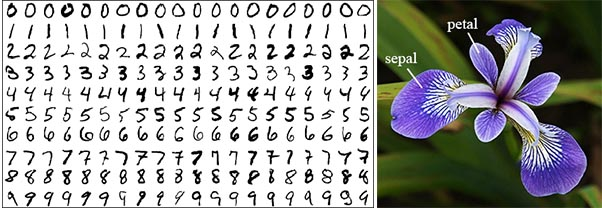

## Packages

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [1]:
# Importing packages
import numpy as np
import random

import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Setting the seed
RAND_ST = 42
random.seed(RAND_ST)
#begin_test

#end_test


## Data Loading

The following cells are used to load both datasets, _Iris_ and _MNIST_.

In [3]:
def load_iris_dataset(num_classes=2):
    # Load the datadet from SkDataset
    iris = skdataset.load_iris()
    X = iris.data
    Y = iris.target
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [4]:
def load_mnist_dataset(num_classes=2):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

def load_mnist_dataset_onevsall(class_id=7):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # One versus all
    idx = Y == class_id
    Y[~idx] = 0
    Y[idx]  = 1
    return X, Y

## Functions for visualization

In [5]:
def plot_dataset(X, Y, dims=[0,1]):
    # Keep only two dimensions
    X_reduced = X[:, dims]
    # Plot the data points
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap=plt.cm.Set1, edgecolor='k')
    plt.xlabel('Feat 1')
    plt.ylabel('Feat 2')
    plt.show()

In [6]:
def plot_correlation(X1, X2):
    # Plot both variables
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X1, X2, edgecolor='k')
    line = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 20)
    plt.plot(line, line, 'r')
    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.show()

In [7]:
def plot_eigenvecs(stacked_images, n_rows, n_columns):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]))
        plt.axis('off')
    plt.show()

def plot_grey_image(stacked_images, n_rows, n_columns, titles):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if len(titles) == n_rows*n_columns:
          plt.title(titles[i])
    plt.show()

In [8]:
def plot_loss_curve(logs):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(logs)
    plt.show()

In [9]:
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0) | (Y_test == -1)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (y_pred == 0) | (y_pred == -1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def false_positive(Y_test, y_pred):
    mask = (y_pred == 1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def plot_confusion_matrix(Y_test, y_pred):
    tp = true_positive(Y_test, y_pred)
    tn = true_negative(Y_test, y_pred)
    fp = false_positive(Y_test, y_pred)
    fn = false_negative(Y_test, y_pred)
    cf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots()
    ax.matshow(cf, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            c = cf[i,j]
            ax.text(j, i, str(c), va='center', ha='center')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()

## Data Loading

In the following cells, the dataset is created with proper splits between training and test set.

_IRIS_ dataset

In [10]:
X, Y = load_iris_dataset(num_classes=3)
X_iris, X_iris_test, Y_iris, Y_iris_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

_MNIST_ dataset

In [11]:
X, Y = load_mnist_dataset(num_classes=10)
X = X / 255.0
X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

## 1. Linear Fitting (10 points)
<a name='question1'></a>

[a)](#question1a) Implement the normal equation solver function **nsolve**, which takes as input the matrix **X** and the target vector **y** and returns the optimized weights **w**. Test your code with your own mockup data. (**5 points**)

[b)](#question1b) Implement **line_fit(X,y)** which should fit a linear function to the input data. Test your implementation on the following task: predict with linear fitting the _petal length (cm)_ of the Iris dataset using the three remaining variables as inputs (_sepal length (cm)_, _sepal width (cm)_ and _petal width (cm)_). Report the L2 loss on the validation set and plot a graph showing the correlation between y and your prediction on the test set. (**2 points**)

[c)](#question1c) Implement **poly_fit(X,y)** which should fit a 2nd degree polynomial to the input data. Test your implementation on the following task: predict with the polynomial the petal width (cm) of the _IRIS_ dataset using the three remaining variables as inputs (sepal length (cm), sepal width (cm), petal length (cm)). The 2nd degree polynomial should consider all possible pairwise terms, i.e. $w_1x^2 + w_2xy+ w_3y^2 + w_4x+ w_5y+ w_6$ in the case of two input variables $x$ and $y$. Report the L2 loss on the validation set and plot a graph showing the correlation between $y$ and your prediction on the test set. (**3 points**)

**Question 1.a**
<a name='question1a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [12]:
def nsolve(X,y):
    
    
    """
    Write your implementation of nsolve here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights 
    """

    #begin_solution
    
    #bias trick for linearity
    X_bias = np.column_stack([np.ones([len(X), 1]), X])

    w = np.matmul(np.linalg.inv(np.matmul(X_bias.transpose(), X_bias)), X_bias.transpose()).dot(y)
    
    #end_solution


    return w

Testing your code on mockup data.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

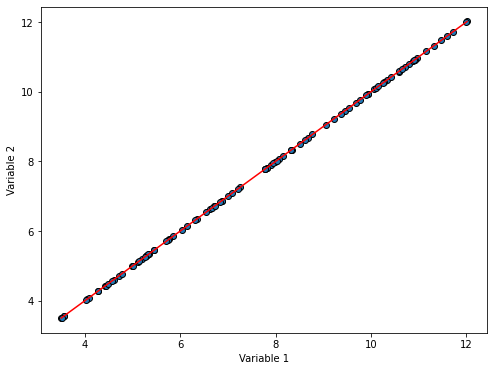

In [13]:
"""
After implementing nsolve, test it below on some mock data using np.random
"""

#begin_solution
sample_size = 100
features = 3

X = np.random.rand(sample_size, features)
my_w = np.random.randint(10, size=features)
y = np.dot(X, my_w) + np.random.randint(10, size=1)
my_w = nsolve(X, y)
y_est = (X @ my_w[1:]) + my_w[0]
plot_correlation(y, y_est)
#end_solution


**Question 1.b**
<a name='question1b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [14]:
def line_fit(X,y):
    """
    Write your implementation of line_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 Prediction error using learned w
    """
    
    #begin_solution
    X_bias = np.column_stack([np.ones([len(X), 1]), X])
    w = nsolve(X, y)
    my_y = X_bias @ w
    l2_loss = 0
    for i in range(len(y)):
      l2_loss += (my_y[i] - y[i])**2
    l2_error = np.sqrt(l2_loss)
    #end_solution


    return w, l2_error

Testing your code on _IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [15]:
"""
After implementing line_fit, test it below on IRIS Train set.
Print the L2 error on the Training set.
"""

#begin_solution
#delete column of X_iris, which corresponds to petal length
X = np.delete(X_iris, 2, axis=1)
#y is the petal length column
y = X_iris[:,2]
w, l2_error = line_fit(X,y)
print(l2_error)
#end_solution


3.5345832054314457


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [16]:
"""
After implementing line_fit, test it below on IRIS Test set.
Print the L2 error with respect to Test set.
"""

#begin_solution
#delete petal length column from X_iris_test set
X_iris_test_new = np.delete(X_iris_test, 2, axis=1)
Y_iris_test_new = X_iris_test[:,2]
y_pred = (X_iris_test_new @ w[1:]) + w[0]
l2_loss = 0

for i in range(len(y_pred)):
    l2_loss += (Y_iris_test_new[i] - y_pred[i])**2
l2_error = np.sqrt(l2_loss)
print(l2_error)

#end_solution


1.5611901785495332


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

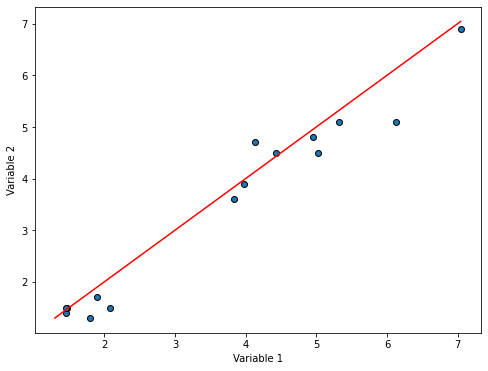

In [17]:
"""
Below, plot and display the correlation between true y and predicted values.
"""
#begin_solution
plot_correlation(y_pred, Y_iris_test_new)
#end_solution


In [18]:
#begin_test

#end_test


**Question 1.c**
<a name='question1c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [19]:
def poly_fit(X,y):
    """
    Write your implementation of poly_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 prediction error using learned w
    """

    #begin_solution
    X_bias = np.column_stack([np.ones([len(X), 1]), X])
    X_cols = []
    for i in range(X_bias.shape[1]):
        for j in range(i, X_bias.shape[1]):
            temp = X_bias[:, i] * X_bias[:, j]
            X_cols.append(temp)

    X_new = np.column_stack(X_cols)

    w = np.matmul(np.linalg.inv(np.matmul(X_new.transpose(), X_new)), X_new.transpose()).dot(y)
    y_pred = X_new @ w
    l2_loss = 0
    for i in range(len(y)):
        l2_loss += (y[i]-y_pred[i])**2
    l2_error = np.sqrt(l2_loss)
    #end_solution
    
    return w, l2_error

Testing your code on _IRIS_.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [20]:
"""
After implementing poly_fit, test it below on IRIS Training set.
Print L2 error with respect to training set.
"""

#begin_solution
X = np.delete(X_iris, 3, axis=1)
y = X_iris[:, 3]
w, l2 = poly_fit(X,y)
print(l2)
#end_solution


2.0450366857110573


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [21]:
"""
After implementing poly_fit, test it below on IRIS Test set.
Print L2 error with respect to test set.
"""

#begin_solution
X_iris_test_new = np.delete(X_iris_test, 3, axis=1)
Y_iris_test_new = X_iris_test[:,3]
X_test_copy = X_iris_test_new.copy()

for i in range(X_test_copy.shape[1]):
    for j in range(i, X_test_copy.shape[1]):
        X_iris_test_new = np.hstack((X_iris_test_new, np.transpose([np.multiply(X_test_copy[:,i], X_test_copy[:,j])])))
Y_iris_test_pred = (X_iris_test_new @ w[1:]) + w[0]
l2_loss = 0
for i in range(len(Y_iris_test_pred)):
    l2_loss += (Y_iris_test_new[i] - Y_iris_test_pred[i])**2
l2_error = np.sqrt(l2_loss)
print(l2_error)

#end_solution


0.8621833315430759


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

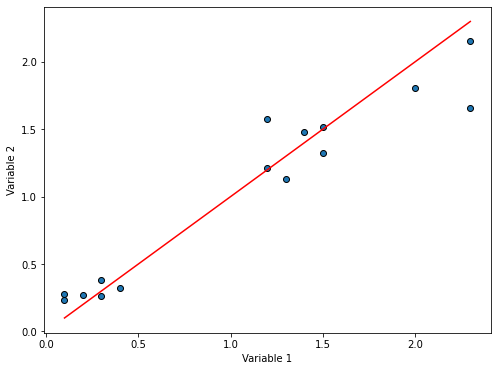

In [22]:
"""
Below, plot and display the correlation between true y and predicted values
"""

#begin_solution
plot_correlation(Y_iris_test_new, Y_iris_test_pred)
#end_solution


In [23]:
#begin_test

#end_test


## 2. Free form optimization (18 points)
<a name='question2'></a>

[a)](#question2a) Implement Gradient Descent (GD) (**3 points**), Gradient Descent with Nesterov Momentum (GDN)  (**4 points**) and a second order optimization method (**4 points**)

[b)](#question2b) Write the gradient and hessian of "paraboloid" and run the optimization methods on it (**7 points** on hidden test)

**Question 2.a**
<a name='question2a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [24]:
def gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change=1.0e-6):
    """
    Write your own implementation of gradient descent here.
    
    Arguments:
    
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     derivative of the function to minimize - R^N -> R^N
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
    
    #begin_solution
    while current_it < max_iterations:
      new_minimizer = minimizer - step_size*d_objective(minimizer)
      diff = np.absolute(objective(new_minimizer) - objective(minimizer))
      if diff < eps_change:
        break
      minimizer = new_minimizer
      current_it += 1
    #end_solution 

        
    return minimizer, current_it + 1
    

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [25]:
def gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change):
    """
    Write your own implementation of gradient descent with Nesterov momentum here.
    
    Arguments:
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     derivative of the function to minimize - R^N -> R^N
    momentum:        weight of the momentum term - R^1
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
    
    #begin_solution
    velocity = np.zeros(N)
    while current_it < max_iterations:
      velocity = momentum*velocity - step_size*d_objective(minimizer + momentum*velocity)
      new_minimizer = minimizer + velocity
      diff = np.absolute(objective(new_minimizer) - objective(minimizer))
      if diff < eps_change:
        break
      minimizer = new_minimizer
      current_it += 1
    #end_solution

        
    return minimizer, current_it + 1
    

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [26]:
def second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change):
    """
    Write your own implementation of a second order optimizer.
    
    Arguments:
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     function computing the derivative of the objective - R^N -> R^N
    dd_objective:    function computing the second derivative of the objective - R^N -> R^NxN
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
    
    #begin_solution
    while current_it < max_iterations:
      new_minimizer = minimizer - step_size*np.matmul(np.linalg.inv(dd_objective(minimizer)),d_objective(minimizer))
      diff = np.absolute(objective(new_minimizer) - objective(minimizer))
      if diff < eps_change:
        break
      minimizer = new_minimizer
      current_it += 1
    #end_solution

        
    return minimizer, current_it + 1
    

In [27]:
def square(X):
    return np.power(X, 2).sum()

def d_square(X):
    return 2 * X

def dd_square(X):
    hessian = np.eye(X.shape[0]) * 2
    return hessian

**Question 2.b**
<a name='question2b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [28]:
def paraboloid(X): # paraboloid or saddle function X[0]^2-X[1]^2+X[2]^2 ... 
    tmp = np.power(X, 2)
    return tmp[0::2].sum() - tmp[1::2].sum()

def d_paraboloid(X):
    gradient = np.zeros(X.shape[0])
    #begin_solution
    i = 0
    for value in X:
      if (i % 2) == 0:
        gradient[i] = 2 * X[i]
      else:
        gradient[i] = -2 * X[i]
      i+=1
    #end_solution

    return gradient

def dd_paraboloid(X):
    hessian = np.eye(X.shape[0])
    #begin_solution
    i = 0

    for i in range(X.shape[0]):
      if (i%2) == 0:
        hessian[i][i] = 2
      else:
        hessian[i][i] = -2
      i+=1
    #end_solution

    return hessian

In [29]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [30]:
parameters     = np.ones(1)
objective      = square
d_objective    = d_square
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

gd_minimizer, gd_it = gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change)

#begin_test
print(gd_minimizer, gd_it)
#end_test


parameters     = np.ones(1)
objective      = square
d_objective    = d_square
momentum       = 0.4
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

nesterov_minimizer, nesterov_it = gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change)

#begin_test
print(nesterov_minimizer, nesterov_it)
#end_test


parameters     = np.ones(1)
objective      = square
d_objective    = d_square
dd_objective   = dd_square
step_size      = 1.0
max_iterations = 200
eps_change     = 1.0e-6

second_minimizer, second_it = second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change)

#begin_test
print(second_minimizer, second_it)
#end_test



[0.00154743] 30
[0.0008042] 15
[0.] 2


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [31]:
parameters     = np.ones(1)
objective      = paraboloid
d_objective    = d_paraboloid
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

gd_minimizer, gd_it = gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change)



#begin_test
print(gd_minimizer, gd_it)

parameters     = np.ones(1)
objective      = paraboloid
d_objective    = d_paraboloid
momentum       = 0.4
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

nesterov_minimizer, nesterov_it = gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change)
print(nesterov_minimizer, nesterov_it)

parameters     = np.ones(1)
objective      = paraboloid
d_objective    = d_paraboloid
dd_objective   = dd_paraboloid
step_size      = 1.0
max_iterations = 200
eps_change     = 1.0e-6

second_minimizer, second_it = second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change)
print(second_minimizer, second_it)
#end_test


[0.00154743] 30
[0.0008042] 15
[0.] 2


In [32]:
#begin_test

#end_test


## 3. Clustering (14 points)
<a name='question3'></a>

[a)](#question3a) Implement a function pca(X, ndims) that performs PCA over the input data X and returns both the mean vector  ̄X and the ndims top components. The top components are the eigen vectors linked to the top eigen values computed from the covariance matrix. Try your function on the _MNIST_ dataset, which is composed of 10 digit classes. Display the top 10 components fitted on the train dataset as images. Next, check that you can reconstruct perfectly an input digit from the test set using all components, by implementing pca_projection(X, mean_vec, eig_vecs) and pca_reconstruction(weights, mean_vec, eig_vecs). (**3 points** + **4 points** on hidden dataset)

[b)](#question3b) Perform independent research on the clustering algorithm k-means. Implement a function kmeans performing k-means on input data X. Propose the interface to that function (i.e., what is its input and output?) and write in three sentences why this is. Apply you kmeans implementation on the _MNIST_ training set with k= 10 clusters and display the centroids as images. (**2 points** + **3 points** on hidden dataset)

[c)](#question3c) Describe the k-means algorithm, highlighting similarities and differences from PCA. Compare the reconstruction loss on the validation set for both k-means and PCA. Write no more than ten sentences. (**2 points**)

**Question 3.a**
<a name='question3a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [33]:
def pca(X, ndims):
    """
    Write your implementation of PCA here.

    Arguments:
    X : Data matrix
    ndims : Number of reduced dimensions

    Returns:
    mean_vec : Data mean
    top_eig_vecs : Selected eigen vectors, a matrix where each column corresponds
                    to an eigen vector
    """

    #begin_solution
    mean_vec = np.mean(X, axis = 0)
    zero_mean = X - mean_vec
    cov = np.cov(zero_mean, rowvar=False)
    e_vals, e_vecs = np.linalg.eigh(cov)
    id_eigv = np.argsort(e_vals)[::-1]
    top_eig_vecs = e_vecs[:,id_eigv[0:ndims]].T
    #end_solution


    return mean_vec, top_eig_vecs

Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

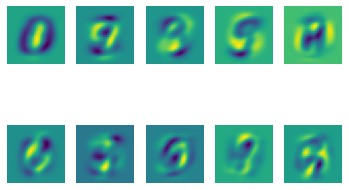

In [34]:
"""
Below, test your PCA on  MNIST dataset.
Plot and display the selected eigen vectors returned by PCA.
"""

#begin_solution
mean_vec, top_eig_vecs = pca(X_mnist, 10)
plot_eigenvecs(top_eig_vecs, 2, 5)
#end_solution


In [35]:
#begin_test

#end_test


Now, we can evaluate if the code is working properly by projecting the first image of the test set on the eigen vectors.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>


In [36]:
def pca_projection(X, mean_vec, eig_vecs):
    """
    Write your implenetation of PCA projection here.

    Arguments:
    X : Data matrix
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector

    Returns:
    weights : Weights corresponding to the eigen vectors
    """

    #begin_solution
    zero_mean = X - mean_vec
    weights = (zero_mean@eig_vecs)
    #end_solution


    return weights

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [37]:
def pca_reconstruction(weights, mean_vec, eig_vecs):
    """
    Write your implementation of PCA reconstruction here.

    Arguments:
    weights : Weights obtained from pca_projection
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector
    """

    #begin_solution
    reconstruction = np.dot(weights, eig_vecs.T) + mean_vec
    #end_solution


    return reconstruction

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

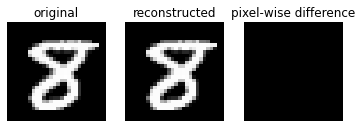

In [38]:
"""
Below, 
1. Perform  PCA on MNIST training set, without reducing dimensions.
2. Project the first image of Test set to the eigen vectors using pca_projection.
3. Reconstruct that image using pca_reconstruction.
4. Display side-by-side, the Test image, its projection and the 
   pixelwise difference between the two. Use the plotting functions provided.
"""

#begin_solution
zero_mean, eig_vecs = pca(X_mnist, X_mnist.shape[1])

weights = pca_projection(X_mnist_test[0], zero_mean, eig_vecs)

reconstruction = pca_reconstruction(weights, zero_mean, eig_vecs)

pixel_diff = X_mnist_test[0] - reconstruction

plot_grey_image(np.stack((X_mnist_test[0], reconstruction, pixel_diff)),1,3,["original", "reconstructed", "pixel-wise difference"])
#end_solution

**Question 3.b**
<a name='question3b'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [39]:
#begin_test

#end_test


In [40]:
def kmeans(X, k, max_iterations=1000):
    """
    Write your implementation of kmeans here.

    Arguments:
    X : Data matrix.
    k : Your choice of k, an integer.
    max_iterations : The number of iterations after which to stop.

    Returns:
    centroids: The learned cluster centroids.
    """

    #begin_solution
    centroids = X[np.random.choice(X.shape[0], k, replace = False)]

    for i in range(max_iterations):
      nn = []
      for i in range(k):
        nn.append(np.zeros(centroids.shape[1]))

      clusters = np.zeros(k)
      for entry in X:
        # get the index of the centroid that is the closest to each img in the
        # data set.
        d_min = np.argmin(np.sqrt(np.sum((centroids - entry) ** 2, axis = -1)))
        nn[d_min] += entry
        clusters[d_min] += 1
      centroids = np.divide(nn, clusters[:, np.newaxis])
    #end_solution


    return centroids

Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

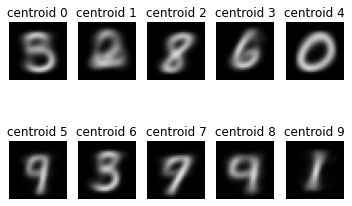

In [41]:
"""
Below, test your kmeans on the MNIST dataset.
For all 10 digits, plot and display the cluster centroids as an image grid. 
Use provided plotting functions.
"""

#begin_solution
centroids = kmeans(X_mnist, 10, 10)
plot_grey_image(centroids, 2, 5, ["centroid " + str(i) for i in range(10)])
#end_solution


**Question 3.c**
<a name='question3c'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply_:

The K-Means Algorithm selects random centroids in a group of data points, it then computes the distance from each centroid to each of the points. The coordinates of each centroid are then adjusted to be the average of the coordinates of the points whose closest centroid is said centroid. We repeat this process iteratively until the coordinates of the centroids don't change or maximum number of iterations has been reached.

PCA provides a way of representing all the data by choosing the most representative features (features where variance is maximum) in the dataset and using them as linear combinations of the rest of the features to reduce complexity.

Both PCA and K-Means aim to minimise the mean-squared reconstruction error and they are both unsupervised learning algorithms.

In [42]:
#begin_test
def pca_error(weights, mean_vec, eig_vecs, x_test):
  pca_error = 0
  for img in x_test:
    reconstruction = pca_reconstruction(weights, mean_vec, eig_vecs)
    pca_error += np.sqrt(np.sum((img - reconstruction)**2, axis = -1))
  return pca_error / x_test.shape[0]

def kmeans_error(centroids, x_test):
  kmeans_error = 0
  for img in x_test:
    kmeans_error += np.min(np.sqrt(np.sum((centroids - img) ** 2, axis = -1)))
  return kmeans_error / x_test.shape[0]



print(f"kmeans reconstruction error: {kmeans_error(centroids, X_mnist_test)}")
print(f"pca reconstruction error: {pca_error(weights, mean_vec, eig_vecs, X_mnist_test)}")
#end_test


kmeans reconstruction error: 6.213189631790256
pca reconstruction error: 11.396632001728118


## 4. Linear Classification (18 points)
<a name='question4'></a>

[a)](#question4a) Implement the normal equation-based binary linear classifier lclass(examplesA, examplesB, testExamples) where the first two arguments are the set of samples from class A and class B respectively and the third is the test. The function should return a vector of 0s and 1s, 0 if test is in A and 1 otherwise. It should, for simplicity, both train and test in one function call. (**3 points**)
Test this on all the samples in _IRIS_, Setosa vs non-Setosa, etc and propose a simple analysis (text, figure, table) of the result you find, but not longer than ten sentences. (**4 points** on hidden dataset)

[b)](#question4b) Perform independent research how to do multi-class classification. Implement lclass_prob(examplesA, examplesB, testExamples) and lmclass(examples, class, testExamples) that together perform multi-class classification of the examples examples according to the vector of labels class of the same size and test it with testExamples by returning a matrix, where each row expresses the probability of a sample in testExamples to belong to each class. Give the accuracy of your model. (**5 points** + **6 points** on hidden dataset)
Present findings applying multi-class classification on _IRIS_ dataset with 3 classes. You can include figures and tables if needed. Write no longer than ten sentences.

**Question 4.a**
<a name='question4a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [43]:
def lclass(examplesA, examplesB, testExample):
    """
    Write your implementation of normal equation based linear classifier here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted 0/1 labels on testExample
    """
    
    #begin_solution
    X = np.vstack((examplesA, examplesB))
    y = np.hstack((np.zeros(examplesA.shape[0]), np.ones(examplesB.shape[0])))
    w = nsolve(X,y)
    preds = (testExample @ w[1:]) + w[0]
    preds[preds > 0.5] = 1
    preds[preds <= 0.5] = 0
    #end_solution


    return preds

_IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [44]:
"""
After implementing lclass, test it below on the IRIS dataset.
"""

#begin_solution
labels_arr = []
preds_arr = []
for i in range(3):
  ids = Y_iris != i
  examplesA = X_iris[ids]
  examplesB = X_iris[~ids]
  my_label_test = np.zeros(Y_iris_test.shape[0])
  my_label_test[Y_iris_test == i] = 1
  preds_arr.append(lclass(examplesA, examplesB, X_iris_test))
  labels_arr.append(my_label_test)
#end_solution


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Setosas vs non-setosas


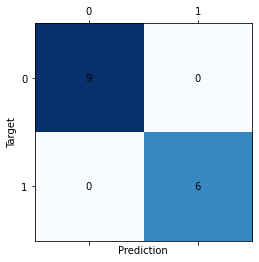

Versicolor vs non-versicolor


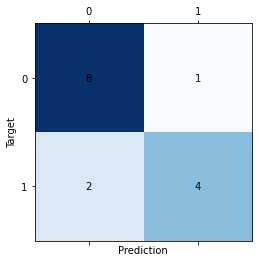

Virginica vs non-virginica


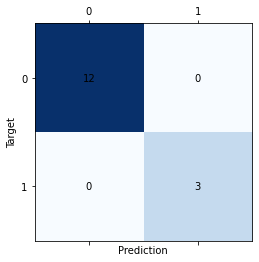

In [45]:
"""
Below, plot and display the confusion matrix of your prediction with respect to 
true values. Use provided functions for plotting.
"""

#begin_solution
print("Setosas vs non-setosas")
plot_confusion_matrix(labels_arr[0], preds_arr[0])
print("Versicolor vs non-versicolor")
plot_confusion_matrix(labels_arr[1], preds_arr[1])
print("Virginica vs non-virginica")
plot_confusion_matrix(labels_arr[2], preds_arr[2])
#end_solution


In [46]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ As per the graphs above, the model is performing accurately; it correctly predicted whether samples were virginica/non-virginica and setosa/non-setosa with 100% accuracy. This is not the case with Versicolor, which means that Versicolor samples are less likely to be separable than setosa and 
virginica.

**Question 4b**
<a name='question4b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [47]:
def softmax(preds):
  """
  Write your implementation of the softmax activation here.

  Arguments:
  preds : The output predicted classes from your classifier

  Returns:
  activation : The outputs after applying softmax activation
  """

  #begin_solution
  activation = np.exp(preds)/np.exp(preds).sum()
  #end_solution


  return activation

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [48]:
def lclass_prob(examplesA, examplesB, testExample):
    """
    Write your implementation of lclass_prob here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted probabilities of samples in testExample belonging to a class.
    """
    
    #begin_solution
    y = np.concatenate((np.ones(examplesA.shape[0]),np.zeros(examplesB.shape[0])))
    X = np.concatenate((examplesA, examplesB))
    w = nsolve(X, y)
    preds = (testExample@w[1:]) + w[0]
    #end_solution

    
    return preds

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [49]:
def lmclass(examples, labels, testExample):
    """
    Write your implementation of multiclass classifier lmclass here.
    Use your lclass_prob implementation here to solve this.

    Arguments:
    examples : The training data matrix
    labels : The training labels
    testExample : The testing data matrix

    Returns:
    preds_prob : For each sample in testExample, their predicted probabilities
                 of belonging to each class
    """

    #begin_solution
    N = max(labels) + 1
    preds_prob = np.zeros((testExample.shape[0], N))
    for i in range(N):
        preds_prob[:, i] = lclass_prob(examples[labels == i], examples[labels != i], testExample)
    preds_prob = np.array([softmax(preds_prob[i]) for i in range(preds_prob.shape[0])])
    #end_solution

    
    return preds_prob

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Accuracy: 0.8666666666666667


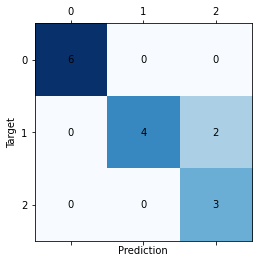

In [50]:
#begin_solution
preds_prob = lmclass(X_iris, Y_iris, X_iris_test)
y_pred = np.argmax(preds_prob, axis=1)

def plot_confusion_matrix_general(Y_test, y_pred, n):
    cm = np.zeros((n, n)).astype(int)
    for i in range(len(Y_test)):
        cm[Y_test[i]][y_pred[i]] += 1
    fig, ax = plt.subplots()
    ax.matshow(cm, cmap=plt.cm.Blues)
    for i in range(n):
        for j in range(n):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.xlabel("Prediction")
    plt.ylabel("Target")
    plt.show()

correct = sum([1 if y_pred[i]==Y_iris_test[i] else 0 for i in range(len(y_pred))])
accuracy = correct/len(y_pred)
print("Accuracy: "+str(accuracy))
plot_confusion_matrix_general(Y_iris_test, y_pred, 3)
#end_solution


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

The model achieves an 86.7% accuracy when used on a sample of 15 data point of the Iris data set. Two out of fifteen points were misclassified. We can expect this to not be a very precise accuracy rating as the sample is very small, however, the performance is adequate.

The source of misclassification comes from our model classifying some Iris Versicolour points as Iris Virginica.

In [51]:
#begin_test

#end_test


## 5. Non-linear Classification (20 points)
<a name='question5'></a>

[a)](#question5a) Implement classification based on logistic regression using GD by implementing the gradient function dlogistic(preds, X, Y) and optimizing using GD. preds are the prediction from the model, X are the data and Y are the labels. Propose a function interface for your implementation of the gradient descent algorithm. (**2 points** + **2 points** on hidden dataset)

[b)](#question5b) Implement classification based on hinge loss using GD by implementing the gradient function dhinge(preds,
W, X, Y) and optimizing using GD. preds are the prediction from the model, W describes the model parameters, X is the data and Y represent the labels. Propose a function interface for your implementation
of the gradient descent algorithm. (**2 points** + **2 points** on hidden dataset)

[c)](#question5c) Implement kernel SVM function ksvm(kernel, X, Y, X_test). The function takes as input a kernel function kernel, training data X, Y and a set of test points X_test. The function returns the set of support vectors along with the predicted labels. You are allowed to use scipy optimization library to solve the quadratic problem of SVM. (**5 points** + **7 points** on hidden dataset)

**Question 5.a**
<a name='question5a'></a>

In [106]:
def gd(X, Y, W,loss_function, loss_gradient, step_size, max_it):
    """
    Implement Gradient Descent here with Logistic loss and its gradient.
    Print the loss values at some interval
    of your choice.

    Arguments:
    X : Data matrix
    Y : Labels
    W : Weights, previously initialized outside this function.
    loss: A callable function that can be used as loss_function(preds,Y) 
              and returns the loss.
    loss_gradient : A callable function that can be used as loss_gradient(preds,X,Y,W=[]) 
              and returns gradient of the loss.
    step_size : Float value of step size to take.
    max_it : Maximum number of iterations, after which to stop

    Returns:
    history : A list containing the loss value at each iteration
    best_w : The best weights corresponding to the best loss value
    """
    
    #begin_solution
    history = []
    best_w = W.copy()
    X = np.append(X, np.ones((X.shape[0], 1)), axis=1)
    W = np.atleast_2d(np.append(W, np.ones((1, 1)), axis=1))
    for i in range(max_it):
      predictions = predict(X, W)
      loss = loss_function(predictions, Y)
      if i % 100 == 0:
        print("i: " + str(i) + ", loss: " + str(loss))
      
      W -= step_size * loss_gradient(predictions, X, Y, W=W)
      history.append(loss)
      
      if loss == min(history):
        best_w = W.copy()
      else:
        best_w
    best_w = best_w[0]
    #end_solution

    
    return history, best_w

Implementation of the sigmoid activation function and Logistic Regression.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [93]:
def sigmoid(z):
    """
    Implement sigmoid activation function here.

    Arguments:
    z : Input scalar or batch of scalars

    Returns:
    activation : Sigmoid activation(s) on z
    """
    
    #begin_solution
    activation = 1/(1+np.exp(-z))
    #end_solution


    return activation

def predict(X, W):
    """
    Implement your prediction function here.

    Arguments:
    X : Data matrix
    W : Weight matrix

    Returns:
    prediction : Predicted values using the weights
    """

    #begin_solution
    prediction = W @ X.T
    #end_solution

    
    return prediction

Implementation of the loss function

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [94]:
def logistic_loss(preds, targets):
    """
    Implement your logistic loss function here.

    Arguments:
    preds : Predicted values
    targets : Target values

    Returns :
    cost : The mean logistic loss value between preds and targets
    """

    #begin_solution
    adj = sigmoid(preds)
    cost = -np.average(targets*np.log(adj)+(1-targets)*np.log(1-adj))
    #end_solution


    return cost

Implementation of the gradient

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [95]:
def dlogistic(preds, X, Y,W=[]):
    """
    Implement the derivative of the logistic loss here.

    Arguments:
    preds : Predicted values
    X : Input data matrix
    Y : True target values
    W : The weights, optional argument, may/may not be needed depending on the loss function
    """

    #begin_solution
    adj = sigmoid(preds)
    J = np.average(X * (adj - np.array([Y])).T, axis=0)
    #end_solution

    
    return J

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Setosa
i: 0, loss: 11.274080847508323
i: 100, loss: 0.3670310177261875
i: 200, loss: 0.23577098827740253
i: 300, loss: 0.1710675529516012
i: 400, loss: 0.13387721244353434
i: 500, loss: 0.11001161766842547
i: 600, loss: 0.093469332517197
i: 700, loss: 0.08134701217497932
i: 800, loss: 0.07208612198985068
i: 900, loss: 0.06478020240646777


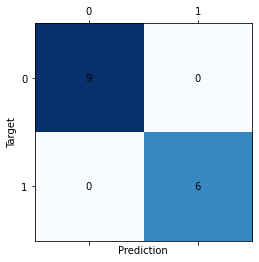

Versicolour
i: 0, loss: 9.919266032796841
i: 100, loss: 0.6334018304406712
i: 200, loss: 0.6259273647989905
i: 300, loss: 0.6205912886984845
i: 400, loss: 0.6162801008866514
i: 500, loss: 0.6125094294594023
i: 600, loss: 0.609056673537428
i: 700, loss: 0.605814693529496
i: 800, loss: 0.6027296212895484
i: 900, loss: 0.5997730252783019


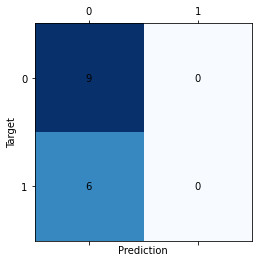

Virginica
i: 0, loss: 8.596303071695413
i: 100, loss: 0.4525359883637648
i: 200, loss: 0.3976713888230558
i: 300, loss: 0.3646573871703703
i: 400, loss: 0.34195754468125134
i: 500, loss: 0.32492206074326546
i: 600, loss: 0.3113567574725947
i: 700, loss: 0.30009595363836794
i: 800, loss: 0.29046218711317207
i: 900, loss: 0.282033350649811


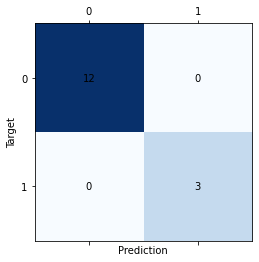

In [111]:
"""
After implementing logistic_loss, dlogistic and gd, test it below using the IRIS dataset.
"""

#begin_solution
def iris_test(label, neglabel, loss_function, loss_gradient, step_size = 0.01, max_it = 1000):
    X = X_iris.copy()
    Y = np.array([1 if i == label else neglabel for i in Y_iris])
    W = np.ones((1, X_iris.shape[1]))
    loss_history, W = gd(X, Y, W, loss_function, loss_gradient, step_size, max_it)
    return loss_history, W

losses = []
classes = ('Setosa', 'Versicolour', 'Virginica')
for i, history in enumerate(np.unique(Y_iris_test)):
    print (classes[i])
    loss_history, W = iris_test(i, 0, logistic_loss, dlogistic)
    Y = np.array([1 if k == i else 0 for k in Y_iris_test])
    X = np.append(X_iris_test, np.ones((X_iris_test.shape[0],1)), axis=1)
    plot_confusion_matrix(Y, np.array([1 if i > 0.5 else 0 for i in sigmoid(predict(X, W))]))
    losses.append(loss_history)
#end_solution


In [69]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Setosa vs non-Setosa


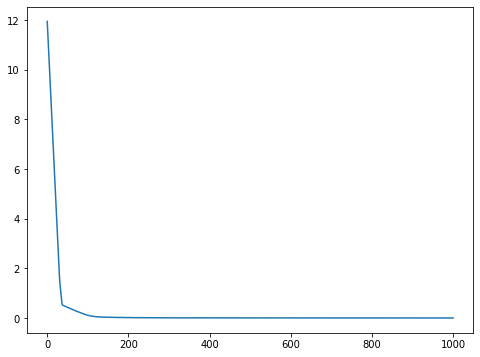

Versicolour vs non-Versicolour


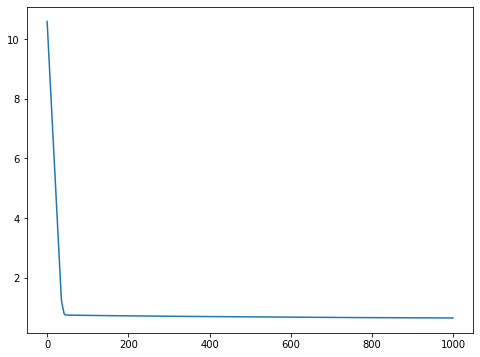

Virginica vs non-Virginica


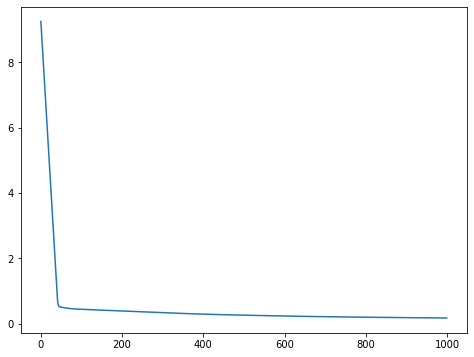

In [122]:
"""
Plot and display the progression of your loss values as a graph. Use the 
provided plotting functions.
"""

#begin_solution
for i, hist in enumerate(losses):
    print (f'{classes[i]} vs non-{classes[i]}')
    plot_loss_curve(hist)
#end_solution


In [71]:
#begin_test

#end_test


**Question 5.b**
<a name='question5b'></a>

Implementation of the Hinge Loss and its gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [118]:
def hinge_loss(z, Y):
    """
    Write your implementation of hinge loss here.

    Arguments:
    z : Classifier score
    Y : Label

    Returns:
    avg : The average hinge loss
    """

    #begin_solution
    loss = []
    for a, b in zip(z.T, Y):
      loss.append(max(0, 1-a[0]*b))
    avg = np.mean(np.array(loss))
    #end_solution


    return avg
  
def dhinge(preds,X, Y, W=[]):
    """
    Implement the derivative of hinge_loss here.

    Arguments:
    preds : The predicted values.
    X : Data matrix
    Y : True Labels
    W : Weights. Optional argument, may/may not be needed, depending on loss function
    Returns:
    J : Gradient of avg hinge_loss with respect to predicted values.
    """

    #begin_solution
    J = []
    for a, b in zip(X, Y):
      if b * (a@W.T)[0] >= 1:
        J.append(np.zeros(W.shape))
      else:
        J.append(-b * np.array([a]))
    J = np.mean(np.array(J), axis = 0)
    #end_solution

    
    return J

Implementation of the full gradient descent:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Setosa vs non-Setosa
i: 0, loss: 11.948148148148148
i: 100, loss: 0.11179863374485578
i: 200, loss: 0.019256104252400444
i: 300, loss: 0.010587807956104157
i: 400, loss: 0.008168109739368934
i: 500, loss: 0.006728674897119314
i: 600, loss: 0.006017234567901275
i: 700, loss: 0.005304735253772592
i: 800, loss: 0.004767648834019296
i: 900, loss: 0.004232724279835567


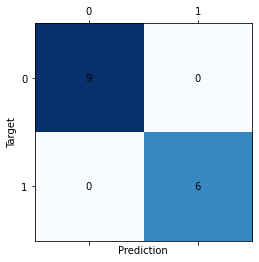

Versicolour vs non-Versicolour
i: 0, loss: 10.593333333333332
i: 100, loss: 0.7312116817558298
i: 200, loss: 0.7160861399176955
i: 300, loss: 0.70319638957476
i: 400, loss: 0.6909410205761318
i: 500, loss: 0.6801047462277091
i: 600, loss: 0.6710661783264746
i: 700, loss: 0.6628624691358026
i: 800, loss: 0.6553709300411524
i: 900, loss: 0.6486574705075447


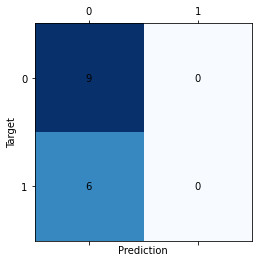

Virginica vs non-Virginica
i: 0, loss: 9.24814814814815
i: 100, loss: 0.4385026227709191
i: 200, loss: 0.38624344581618686
i: 300, loss: 0.33421350891632406
i: 400, loss: 0.2902821618655697
i: 500, loss: 0.2578532345679012
i: 600, loss: 0.23181820576131662
i: 700, loss: 0.21196150891632384
i: 800, loss: 0.19580824691357995
i: 900, loss: 0.1829749629629623


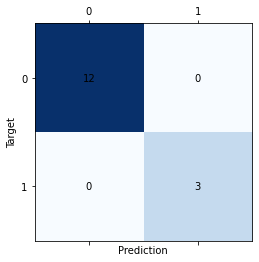

In [119]:
"""
After implementing hinge_loss, dhinge and gd, test it below on the IRIS dataset.
"""

#begin_solution
losses = []
for i, hist in enumerate(np.unique(Y_iris_test)):
    print (f'{classes[i]} vs non-{classes[i]}')
    loss_history, W = iris_test(i, -1, hinge_loss, dhinge)
    Y = np.array([1 if k == i else -1 for k in Y_iris_test])
    X = np.append(X_iris_test, np.ones((X_iris_test.shape[0],1)), axis=1)
    plot_confusion_matrix(Y, np.array([1 if i > 0 else -1 for i in predict(X, W)]))
    losses.append(loss_history)
#end_solution


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Setosa vs non-Setosa


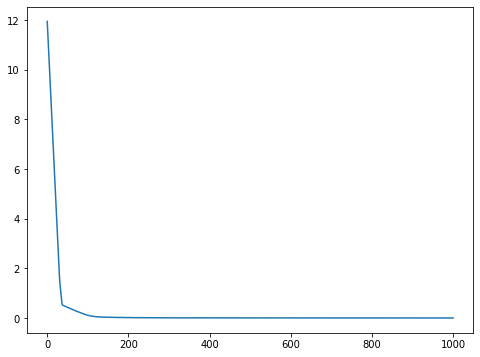

Versicolour vs non-Versicolour


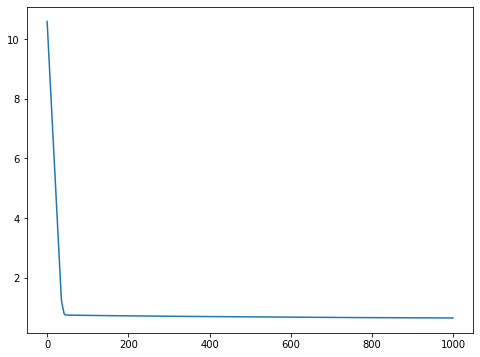

Virginica vs non-Virginica


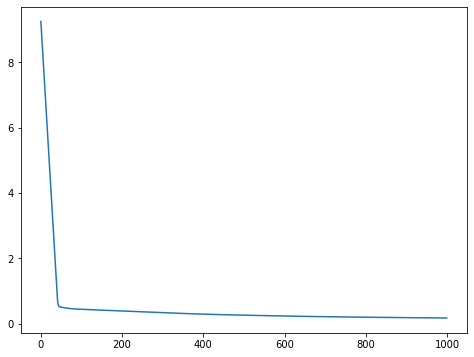

In [121]:
"""
Print the minimum loss
Plot and display the progression of loss. Use provided plotting functions
"""

#begin_solution
for i, hist in enumerate(losses):
    print (f'{classes[i]} vs non-{classes[i]}')
    plot_loss_curve(hist)
#end_solution


In [ ]:
#begin_test

#end_test


**Question 5.c**
<a name='question5c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def ksvm(kernel, X, Y, X_test):
    """
    Write your implementation of Kernel SVM here.

    Arguments:
    kernel : A callable function that takes 2 samples and returns the score
             for them.
    X : Training data matrix
    Y : Training Labels as -1/1
    X_test : Test data matrix

    Returns:
    support_vectors : The learned support vectors
    preds : The predicted labels as -1/1 on the given Test data
    """
    
    #begin_solution

    #end_solution


    return support_vectors, preds

In [ ]:
X_iris_svm = np.copy(X_iris)
Y_iris_svm = np.copy(Y_iris)
Y_iris_svm[Y_iris==0] = -1
Y_iris_svm[Y_iris!=0] = 1

Y_iris_test_svm = np.copy(Y_iris_test)
Y_iris_test_svm[Y_iris_test==0] = -1
Y_iris_test_svm[Y_iris_test!=0] = 1

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def kernel(x1, x2):
    """
    Define your kernel function here.

    Arguments:
    x1, x2 : Two data samples (vectors)

    Returns:
    score : The score between x1 and x2
    """

    #begin_solution

    #end_solution


    return score

"""
After implementing ksvm and kernel, test it below on the IRIS dataset.
Print the accuracy of the model.
"""

#begin_solution

#end_solution


In [ ]:
#begin_test

#end_test


## 6. Neural Networks (20 points)
<a name='question6'></a>

[a)](#question6a) Devise a three-layer neural network with n hidden states and sigmoid activations for classification. Explain how many parameters this has in one sentence. (**2 points**)

[b)](#question6b) Implement the binary classifier nnclass(examplesA, examples, testExamples) that is trained with your implementation of (stochastic) GD and your gradient function using the network. (**5 points** + **7 points** on hidden dataset)

[c)](#question6c) Do an analysis how changes affect the accuracy with _MNIST_. Positive labels are assigned to digit 1 and negative samples to other digits. Write no longer than fifteen sentences. A table and / or plot is welcome. (**6 points**)

**Question 6.a**
<a name='question6a'></a>

_Your reply:_ Let 'k' be the number of nodes in the input layer and 't' be the number of nodes in the output layer. This means there will be 'kn' weights from input to the hidden state plus 'n' biases. There will be 'tn' weights from hidden state onto the output layer, plus 't' biases. Hence, the total number of parameters is 'kn' + 'n' + 'tn' + t.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

**Question 6.b**
<a name='question6b'></a>

In [ ]:
def sigmoid(z):
    """
    Write your activation function here.

    Arguments:
    z : Scalar or batch of scalars on which to compute activation(s)

    Returns:
    activation : The activation value(s)
    """

    #begin_solution

    #end_solution


    return activation

def dsigmoid(z):
    """
    Implement the gradient of the activation function.

    Arguments:
    z : Scalar or batch of scalars

    Returns:
    gradient : Gradient(s) of the activation function
    """

    #begin_solution

    #end_solution


    return gradient

In [ ]:
#begin_test

#end_test


Implementation of the forward pass:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def forward_pass(x, W, b):
    """
    Write your implementation of forward pass here.

    Arguments:
    x : Input data matrix
    W : Tuple of weight matrices
    b : Tuple of biases

    Returns:
    y_hat : Output of last layer
    cache : A tuple, that contains all intermediate outputs. These will be
            needed in your backward pass. Save anything in cache that you
            plan to use in the backward pass. It should be a tuple
    """

    #begin_solution

    #end_solution


    return y_hat, cache

#begin_test

#end_test


Implementation of the loss and its associated gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def loss(preds, targets):
    """
    Write your loss function here.

    Arguments:
    preds: The network predictions
    targets: The true labels

    Returns:
    cost: An error metric between pred and targets
    """

    #begin_solution

    #end_solution

    
    return cost

def dloss(preds, target):
    """
    Write the derivative of loss function here.

    Arguments:
    preds : The network predictions
    target : The true labels

    Returns:
    gradient : The derivative of loss function with respect to the
              network outputs
    """

    #begin_solution

    #end_solution


    return gradient

In [ ]:
#begin_test

#end_test


Implementation of the backward pass:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def backward_pass(preds, targets, W, b, X, cache):
    """
    Write your implementation of backward_pass here.

    Arguments:
    preds : The network predictions
    targets : The true labels
    W : A tuple of weight matrices
    b : A tuple of bias values
    X : Input data matrix
    cache : Tuple of Intermediate outputs that you cached in forward_pass

    Returns:
    Gradients with respect to each layer's weights and biases
    """
    
    #begin_solution

    #end_solution

    
    return J_w3, J_w2, J_w1, J_b3, J_b2, J_b1

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def training(X, Y, W, b, step_size, max_it):
    """
    Implement your training loop here.

    Arguments:
    X : Input Data matrix
    Y : True labels
    W : A tuple of weight matrices
    step_size : The step size to take for network updates
    max_it : The maximum iterations after which to stop

    Returns:
    W : The trained weights
    b : The trained biases
    history : A list of your loss values at each iteration
    """
    
    #begin_test

    #end_test

    
    #begin_solution

    #end_solution

    
    #begin_test

    #end_test

            
    return W, b, history

In [ ]:
#begin_test

#end_test


In [ ]:
"""
Below, initialize the weights and biases randomly.
Start your training loop with your choice of parameters step_size, max_it
"""

#begin_solution

#end_solution




**Question 6.c**
<a name='question6d'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

In [ ]:
#begin_test

#end_test
